In [1]:
!rm -rf dso-560-nlp-text-analytics && git clone https://github.com/ychennay/dso-560-nlp-text-analytics

Cloning into 'dso-560-nlp-text-analytics'...
remote: Enumerating objects: 3206, done.
remote: Total 3206 (delta 0), reused 0 (delta 0), pack-reused 3206
Receiving objects: 100% (3206/3206), 95.46 MiB | 14.61 MiB/s, done.
Resolving deltas: 100% (411/411), done.
Checking out files: 100% (3186/3186), done.


In [4]:
%cd dso-560-nlp-text-analytics

/content/dso-560-nlp-text-analytics


# Attention and Transformers

The original *Attention Is All You Need* paper is [available here](https://arxiv.org/pdf/1706.03762.pdf).

The overall architecture of the **Transformer** model is defined here from the paper:
![transformers](https://github.com/ychennay/dso-560-nlp-text-analytics/blob/main/images/transformers.png?raw=1)

## Define Configurations

In [2]:
VOCAB_SIZE = 25000

In [3]:
from keras.layers import Input, Dense, LSTM, Flatten, concatenate, Activation, RepeatVector, Permute
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
import numpy as np 
import spacy
nlp = spacy.load('en_core_web_sm', disable=["pos", "ner", "tagger"])

## Load in Amazon Reviews Dataset

In [66]:
# import numpy as np
# NUM_SAMPLES = 2000

# good_reviews = open("datasets/good_amazon_toy_reviews.txt").readlines()
# bad_reviews = open("datasets/poor_amazon_toy_reviews.txt").readlines()

# sampled_good_reviews = good_reviews[:NUM_SAMPLES]
# sampled_bad_reviews = bad_reviews[:NUM_SAMPLES]

# docs = sampled_good_reviews + sampled_bad_reviews
# labels = np.concatenate([np.ones(NUM_SAMPLES), np.zeros(NUM_SAMPLES)])

## Remove Stopwords

In [4]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
link = 'https://drive.google.com/file/d/1MSsJGBwUKRBxTUPSl03KXeRIgHYTN8Dl/view?usp=sharing'
 
import pandas as pd
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('xclara.csv') 
 
df = pd.read_csv('xclara.csv')
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,negative_regex,positive_regex
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/17,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3,52.360576,4.915968,room dirty afraid walk barefoot floor look not...,great location nice surroundings bar restauran...
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/17/17,7.7,Hotel Arena,United Kingdom,Cleaner did not change our sheet and duvet ev...,33,1403,The room is spacious and bright The hotel is ...,18,6,4.6,"[' Leisure trip ', ' Group ', ' Duplex Twin Ro...",17,52.360576,4.915968,cleaner not change sheet duvet everyday bed di...,room spacious bright locate quiet beautiful park
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/17/17,7.7,Hotel Arena,United Kingdom,Apart from the price for the brekfast Everyth...,11,1403,Good location Set in a lovely park friendly s...,19,1,10.0,"[' Leisure trip ', ' Couple ', ' Duplex Double...",17,52.360576,4.915968,apart price breakfast good,good location set lovely park friendly staff f...
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/7/17,7.7,Hotel Arena,United Kingdom,Nothing all great,5,1403,Rooms were stunningly decorated and really sp...,101,2,10.0,"[' Leisure trip ', ' Group ', ' Duplex Double ...",27,52.360576,4.915968,great,room stunningly decorate spacious building pic...
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/6/17,7.7,Hotel Arena,United Kingdom,The floor in my room was filfy dirty Very bas...,28,1403,Comfy bed good location,6,7,4.6,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",28,52.360576,4.915968,floor room filthy dirty basic room _NUMBER_ ol...,comfortableee bed good location


In [11]:
neg=pd.DataFrame()

In [12]:
pos=pd.DataFrame()

In [13]:
neg['review'] = df['negative_regex']

In [14]:
pos['review'] = df['positive_regex']

In [15]:
pos.isnull().sum()

review    842
dtype: int64

In [16]:
neg.isnull().sum()

review    7350
dtype: int64

In [17]:
pos.dropna(inplace=True)

In [18]:
neg.dropna(inplace=True)

In [19]:
neg['label']=0

In [23]:
review.tail()

,review,label
241565,little food availability,0
241566,small reception small _NUMBER_ hour bar,0
241567,room warm,0
241568,no negative,0
241569,_NUMBER_ lift floor,0


In [21]:
pos['label']=1

In [22]:
review = pd.concat([pos,neg]).reset_index(drop=True)

In [79]:
# stopwords_removed_docs = list(
#     map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), docs))

## Tokenize Text

In [24]:
docs = review['review']
type(docs)

pandas.core.series.Series

In [25]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10_000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(docs)

## Integer Encode Documents

In [26]:
docs

0         great location nice surroundings bar restauran...
1         room spacious bright locate quiet beautiful park 
2         good location set lovely park friendly staff f...
3         room stunningly decorate spacious building pic...
4                          comfortableee bed good location 
                                ...                        
241565                            little food availability 
241566             small reception small _NUMBER_ hour bar 
241567                                           room warm 
241568                                         no negative 
241569                                 _NUMBER_ lift floor 
Name: review, Length: 241570, dtype: object

In [27]:
from typing import List
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

# get the max length in terms of token length
max_length = get_max_token_length_per_doc(docs)
print(f"Max length of sequences is {max_length}")

def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 100
# integer encode the documents
encoded_docs = integer_encode_documents(docs, tokenizer)
# this is a list of lists, the numbers represent the index position of that word.
# for instance, 33 means the 33rd word in the vocabulary
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

Max length of sequences is 190


In [28]:
len(padded_docs)

241570

## Load in GloVe Vectors
Download the actual Glove vectors from S3 and unzip them.

In [29]:
!wget https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
!unzip glove6b100dtxt.zip 

--2022-05-12 12:49:49--  https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
Resolving dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)... 52.217.110.108
Connecting to dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)|52.217.110.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137847651 (131M) [application/zip]
Saving to: ‘glove6b100dtxt.zip’

glove6b100dtxt.zip  100%[===================>] 131.46M  41.8MB/s    in 3.1s    

2022-05-12 12:49:52 (41.8 MB/s) - ‘glove6b100dtxt.zip’ saved [137847651/137847651]

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [30]:
import numpy as np
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


## Load in Embeddings Matrix

In [31]:
# create a weight matrix for words in training docs
VOCAB_SIZE = 25_000
embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

## Define an LSTM Model

In [35]:
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking
from keras.layers import Embedding
import keras

In [30]:
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking
from keras.layers import Embedding
import keras
def make_lstm_classification_model(plot=False, sequence_length = 100, vocab_size = 25000):
    model = keras.models.Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=sequence_length, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=64, input_shape=(1, sequence_length)))
    model.add(Dense(16))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

## Inside One LSTM Cell
![LSTM](https://github.com/ychennay/dso-560-nlp-text-analytics/blob/main/images/lstm_architecture.jpg?raw=1)

In [31]:
lstm_model = make_lstm_classification_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          2500000   
                                                                 
 masking (Masking)           (None, 100, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,543,297
Trainable params: 43,297
Non-trainable params: 2,500,000
_________________________________________________________________


## Split Into Train/Test

In [36]:
labels=review['label']

In [37]:
len(padded_docs)

241570

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.2)

#### Train LSTM Model

In [35]:
# fit the model
history = lstm_model.fit(padded_docs, labels, validation_split = 0.1, epochs=3, verbose=1)

Epoch 1/3
6795/6795 [==============================] - 897s 131ms/step - loss: 0.1372 - accuracy: 0.9470 - val_loss: 0.1205 - val_accuracy: 0.9573
Epoch 2/3
6795/6795 [==============================] - 883s 130ms/step - loss: 0.1089 - accuracy: 0.9590 - val_loss: 0.0966 - val_accuracy: 0.9668
Epoch 3/3
6795/6795 [==============================] - 879s 129ms/step - loss: 0.0984 - accuracy: 0.9628 - val_loss: 0.1276 - val_accuracy: 0.9574


In [ ]:
import matplotlib.pyplot as plt # From https://keras.io/visualization/


def plot_performance(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_performance(history)

# Ways to Improve Performance

* **feature engineer** the text by grouping collocated tokens, removing stopwords, etc.

* **use K-Folds cross-validation** to "use" more of the dataset in the training/validation/testing process.

* **train your own custom domain-specific embeddings** (instead of using generic pre-trained ones)

* **tune hyperparameters** - neural network architecture, activation functions, etc. 

* **enrich the data** using augmented datasets as features

## Self Attention Model

Let's define a function to generate our self attention model. We'll install another library that augments Keras and creates self attention layers for us to use called `keras_self_attention` ([Github](https://pypi.org/project/keras-self-attention/)).

In [32]:
!pip install keras_self_attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=94d7e83298e2c20876d220ec4affa5c9c8845d6fc2364edafa4b21901c1b48af
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [39]:
from keras_self_attention import SeqSelfAttention
def make_self_attention_model(vocab_size=25_000, sequence_length = 100):
    model = keras.models.Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=sequence_length, trainable=False))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=300,
                                                           return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(keras.layers.Dense(units=1))
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )
    model.summary()
    return model

### Notes:

Each LSTM has a hidden state and memory. You can ask `keras` to return the vectors that represent these sequences by using:

#### Difference Between `return_sequences` and `return_states`

```python
LSTM(HIDDEN_STATE_DIMENSIONS, return_sequences=True)
```

If you had a `SEQUENCE_LENGTH` of **20**, and a `HIDDEN_STATE_DIMENSIONS` of **64**, then you'll produce a matrix of shape `64 x 20` as your `return_sequence`.

On the other hand, `return_states` will return both the memory cells (`c`) as well as the hidden state `h`:

```
lstm, state_h, state_c = LSTM(..., return_state=True)
```

Here, `lstm` will be your LSTM model, `state_h` is your hidden state, and `state_c` is your cell memory state. 

Example from [Keras Returning Hidden State in RNNs](http://digital-thinking.de/keras-returning-hidden-state-in-rnns/):
```
inputs1 = Input(shape=(5, 1))
lstm1, state_h, state_c = LSTM(1, return_state=True, return_sequences=True)(inputs1)
model = Model(inputs=inputs1, outputs=[lstm1, state_h, state_c])
data = array([0.1, 0.2, 0.3, 0.4, 0.5]).reshape((1,5,1))
print(model.predict(data))
```
The output of this is
```
[array([[[0.00734747],
        [0.02000349],
        [0.03651035],
        [0.05576567],
        [0.07689518]]], dtype=float32), array([[0.07689518]], dtype=float32), array([[0.15496857]], dtype=float32)]
```

## Model High-Level Architecture
![architecture](https://github.com/ychennay/dso-560-nlp-text-analytics/blob/main/images/lstm_arch.png?raw=1)

In [40]:
attention_model = make_self_attention_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2500000   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 600)         962400    
 l)                                                              
                                                                 
 seq_self_attention (SeqSelf  (None, 100, 600)         38465     
 Attention)                                                      
                                                                 
 dense (Dense)               (None, 100, 1)            601       
                                                                 
Total params: 3,501,466
Trainable params: 1,001,466
Non-trainable params: 2,500,000
_________________________________________________________________


In [41]:
attention_history = attention_model.fit(padded_docs, labels,validation_split = 0.1, epochs=3, verbose=1)

Epoch 1/3
6795/6795 [==============================] - 5469s 804ms/step - loss: 0.3221 - accuracy: 0.8836 - val_loss: 0.3098 - val_accuracy: 0.9229
Epoch 2/3
6795/6795 [==============================] - 5554s 817ms/step - loss: 0.9237 - accuracy: 0.8790 - val_loss: 0.2289 - val_accuracy: 0.9716
Epoch 3/3
6795/6795 [==============================] - 5652s 832ms/step - loss: 3.5257 - accuracy: 0.7618 - val_loss: 6.3126e-04 - val_accuracy: 1.0000


In [45]:
import matplotlib.pyplot as plt # From https://keras.io/visualization/


def plot_performance(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

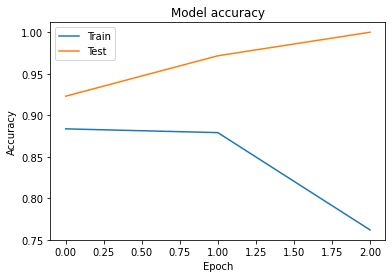

In [46]:
plot_performance(attention_history)

In [47]:
weights = attention_model.get_weights()
print(f"The sequence length is {MAX_SEQUENCE_LENGTH}.")
print(f"The input is of shape {X_train.shape}.")
print(f"The vocabulary size is {VOCAB_SIZE}.")
print(f"The word embedding dimensions size is 100.")
print(f"The hidden state dimension size is {MAX_SEQUENCE_LENGTH}.")

weight_purposes = ["word_embeddings", 
                   "data_gate_weights", 
                   "hidden_state_gate_weights",
                   "attention "]

for weights in attention_model.get_weights():
    print(np.array(weights).shape)

The sequence length is 100.
The input is of shape (193256, 100).
The vocabulary size is 25000.
The word embedding dimensions size is 100.
The hidden state dimension size is 100.
(25000, 100)
(100, 1200)
(300, 1200)
(1200,)
(100, 1200)
(300, 1200)
(1200,)
(600, 32)
(600, 32)
(32,)
(32, 1)
(1,)
(600, 1)
(1,)


In [49]:
weights

array([0.06868321], dtype=float32)

# BERT (Bi-Directional Encoder Representations of Transformers)

## High Level Architecture

![bert](https://github.com/ychennay/dso-560-nlp-text-analytics/blob/main/images/bert_architecture.png?raw=1)

![comparison](https://github.com/ychennay/dso-560-nlp-text-analytics/blob/main/images/bert.webp?raw=1)